## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [31]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


### Выводы 7.1.
* Пустые значения отстствуют.
* Столбец date содержит данные типа object.

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [33]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')


In [34]:
data.groupby('group')['date'].min()  # начальная (минимальная) дата наблюдения в каждой группе


group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]

In [35]:
data.groupby('group')['date'].max()  # конечная (максимальная) дата наблюдения в каждой группе

group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]

### Выыоды 7.2
* Тестирование проводилось со 2 января по 24 января 2021 года.
* Cроки проведения тестирования для групп совпадают.

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [36]:
# группируем данные по А и Б, считаем суммарное количество поспещений, количество покупок, сумму покупок revenue.

data.groupby(['group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).rename(
                                               columns={'user_id':'cnt_users', 
                                                        'purchase':'cnt_purchase', 
                                                        'price':'revenue'})

,cnt_users,cnt_purchase,revenue
group,,,
A,147202,17723,1436260000
B,147276,17514,1554100000


### Выводы 7.3.
* Количество посещений в группе А: 147 202, в группе В: 147 276.
* Суммарное количество покупок в групе А: 17 723, в группе В: 17 514.
* Сумма покупок в группе А: 1 436.26 млн. руб., в группе В: 1 554.1 млн. руб.

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [37]:
# списки пользователей из групп А и В (в виде np.ndarray) проверим на пересечение с помощью np.intersect1d

intersectid_id = np.intersect1d(data[data['group']=='A'].user_id.to_numpy(), 
                                data[data['group']=='B'].user_id.to_numpy())

display(f'Количество пользователей попавших в обе группы: {len(intersectid_id)}')

'Количество пользователей попавших в обе группы: 1895'

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

In [38]:
updated_data = data[~data['user_id'].isin(intersectid_id)]
updated_data.shape

(290688, 5)

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

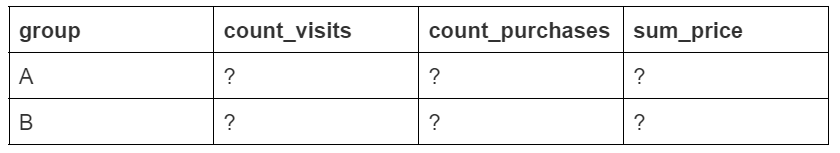
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [39]:
updated_data_piv = updated_data.groupby(['group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).rename(
                                               columns={'user_id':'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})
updated_data_piv.head()

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


In [40]:
display(f"Количество посещений сайта в группе А: {updated_data_piv.at['A', 'count_visits']}" 
        + f" в группе В: {updated_data_piv.at['B', 'count_visits']}.")

'Количество посещений сайта в группе А: 145307 в группе В: 145381.'

Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

### Выводы 7.5.
* Предварительный анализ показывает, что разница в количестве посещений двух групп не больше десятых долей процента.
* Можно считать выборки сбалансированными.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [41]:
updated_data_piv['convertion'] = updated_data_piv['count_purchases'] / updated_data_piv['count_visits'] * 100
updated_data_piv['mean_check'] = updated_data_piv['sum_price'] / updated_data_piv['count_purchases']

display(f"Конверсия в группе А равна {updated_data_piv.at['A', 'convertion']:.2f} процентов")
display(f"Конверсия в группе В равна {updated_data_piv.at['B', 'convertion']:.2f} процентов")

display(f"Средний чек группы А: {updated_data_piv.at['A', 'mean_check']:,.0f} рублей," 
        + f" группы В: {updated_data_piv.at['B', 'mean_check']:,.0f} рублей")

'Конверсия в группе А равна 12.03 процентов'

'Конверсия в группе В равна 11.89 процентов'

'Средний чек группы А: 81,076 рублей, группы В: 88,665 рублей'

Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

### Выводы 7.6.
* Величина конверсии расчитанной для группы А 12.03%, что немного выше конверсии группы B составившей 11.89%.
* В тоже время средний чек группы А: 81 076 рублей. Что заметно ниже среднего чека группы В составившего 88 665 рублей.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [42]:
# фильтруем данные с продажами, группируем по цене и группе
purchases_pivot_table = pd.pivot_table(updated_data[updated_data['purchase']==1], 
                                       values='purchase', index='price', columns='group', aggfunc='count')
display(purchases_pivot_table)

group,A,B
price,,
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

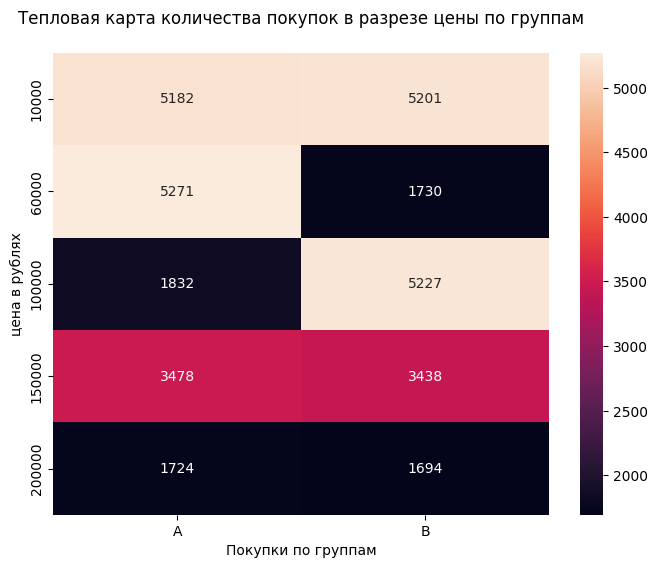

In [43]:
fig, ax = plt.subplots(1, figsize=(8,6))
sns.heatmap(purchases_pivot_table, annot=True, fmt='.0f')

ax.set_title('Тепловая карта количества покупок в разрезе цены по группам\n')
ax.set(xlabel="Покупки по группам", ylabel='цена в рублях');

In [44]:
display(f"Количество проданных туров за 60 тысяч рублей в группе А: {purchases_pivot_table.at[60000, 'A']} штук.")
display(f"Количество проданных туров за 60 тысяч рублей в группе B: {purchases_pivot_table.at[60000, 'B']} штук.")

'Количество проданных туров за 60 тысяч рублей в группе А: 5271 штук.'

'Количество проданных туров за 60 тысяч рублей в группе B: 1730 штук.'

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

### Выводы 7.7.
* Нам было известно из предыдущего анализа, что общее количество продаж примерно одинаково.
* Анализ продаж в разрезе цены показывает, что в группе В чаще преобретали туры стоимостью 100 тыс. рублей, чем туры стоимостью 60 тыс. рублей.
* В группе А наоборот туры стоимостью 60 тыс. рублей были более популярны.
* Соответвенно и количество продаж туров стоимостью 100 тыс. руб. в группе В было намного больше, чем в группе А.
* Что коменсировалось большими продажами туров за 60 тыс. руб в группе А.
* В остальных ценовых категориях существенных различий между группами не наблюдается.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [45]:
days_data = updated_data.groupby(['date', 'group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).rename(
                                               columns={'user_id':'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})

days_data['convertion'] = days_data['count_purchases'] / days_data['count_visits'] * 100
days_data['mean_check'] = days_data['sum_price'] / days_data['count_purchases']

display(days_data.head())
display(f"Конверсия 3 января 2021 года в группе А: {days_data.at[(pd.to_datetime('2021-01-03'), 'A'), 'convertion']:.2f}%.",
        f"Конверсия 3 января 2021 года в группе B: {days_data.at[(pd.to_datetime('2021-01-03'), 'B'), 'convertion']:.2f}%.",
        f"Средний чек 3 января 2021 года в группе А: {days_data.at[(pd.to_datetime('2021-01-03'), 'A'), 'mean_check']:,.0f} рублей.",
        f"Средний чек 3 января 2021 года в группе B: {days_data.at[(pd.to_datetime('2021-01-03'), 'B'), 'mean_check']:,.0f} рублей."
        )

count_visits  count_purchases  sum_price  convertion   
date       group                                                         
2021-01-02 A              2854              359   29410000   12.578837  \
           B              2861              345   29660000   12.058721   
2021-01-03 A              6596              748   62000000   11.340206   
           B              6619              754   65960000   11.391449   
2021-01-04 A              6566              799   64250000   12.168748   

                    mean_check  
date       group                
2021-01-02 A      81922.005571  
           B      85971.014493  
2021-01-03 A      82887.700535  
           B      87480.106101  
2021-01-04 A      80413.016270

'Конверсия 3 января 2021 года в группе А: 11.34%.'

'Конверсия 3 января 2021 года в группе B: 11.39%.'

'Средний чек 3 января 2021 года в группе А: 82,888 рублей.'

'Средний чек 3 января 2021 года в группе B: 87,480 рублей.'

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [46]:
days_data_cum = pd.concat(
                         [days_data,
                          days_data.groupby('group')[
                                                     ['count_visits', 'count_purchases', 'sum_price']
                                                    ].cumsum().add_prefix('cum_', axis=1)],
                          axis=1
                          )
days_data_cum['cum_convertion'] = days_data_cum['cum_count_purchases'] / days_data_cum['cum_count_visits'] * 100
days_data_cum['cum_mean_check'] = days_data_cum['cum_sum_price'] / days_data_cum['cum_count_purchases']

display(days_data_cum.head())
display("Куммулятивная конверсия в группе В на 20 января составила" 
        + f" {days_data_cum.at[(pd.to_datetime('2021-01-20'), 'B'), 'cum_convertion']:.2f}%")
display("Куммулятивный средний чек в группе А на 12 января составил"
        + f" {days_data_cum.at[(pd.to_datetime('2021-01-12'), 'A'), 'cum_mean_check']:,.0f} рублей")


count_visits  count_purchases  sum_price  convertion   
date       group                                                         
2021-01-02 A              2854              359   29410000   12.578837  \
           B              2861              345   29660000   12.058721   
2021-01-03 A              6596              748   62000000   11.340206   
           B              6619              754   65960000   11.391449   
2021-01-04 A              6566              799   64250000   12.168748   

                    mean_check  cum_count_visits  cum_count_purchases   
date       group                                                        
2021-01-02 A      81922.005571              2854                  359  \
           B      85971.014493              2861                  345   
2021-01-03 A      82887.700535              9450                 1107   
           B      87480.106101              9480                 1099   
2021-01-04 A      80413.016270             16016                 1906   

                  cum_sum_price  cum_convertion  cum_mean_check  
date       group                                                 
2021-01-02 A           29410000       12.578837    81922.005571  
           B           29660000       12.058721    85971.014493  
2021-01-03 A           91410000       11.714286    82574.525745  
           B           95620000       11.592827    87006.369427  
2021-01-04 A          155660000       11.900599    81668.415530

'Куммулятивная конверсия в группе В на 20 января составила 11.90%'

'Куммулятивный средний чек в группе А на 12 января составил 81,492 рублей'

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

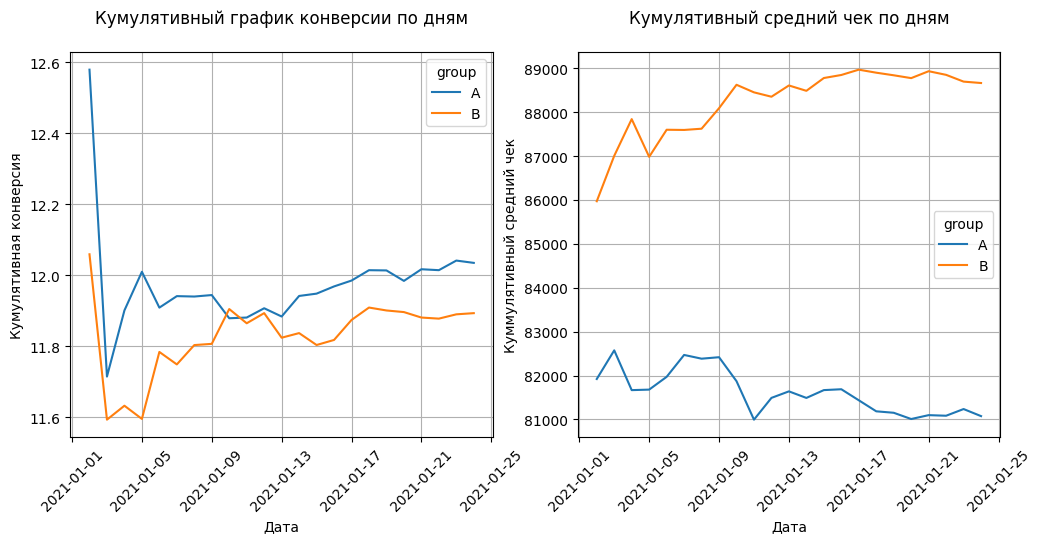

In [47]:
fig1, ax1 = plt.subplots(1, 2, figsize=(12,5))
sns.lineplot(
    data=days_data_cum,
    x='date',
    y='cum_convertion',
    hue='group',
    ax=ax1[0]
)
ax1[0].set_title('Кумулятивный график конверсии по дням\n')
ax1[0].grid(True)
ax1[0].xaxis.set_tick_params(rotation = 45)
ax1[0].set(xlabel="Дата", ylabel='Кумулятивная конверсия');

sns.lineplot(
    data=days_data_cum,
    x='date',
    y='cum_mean_check',
    hue='group',
    ax=ax1[1]
)
ax1[1].set_title('Кумулятивный средний чек по дням\n')
ax1[1].grid(True)
ax1[1].xaxis.set_tick_params(rotation = 45)
ax1[1].set(xlabel="Дата", ylabel='Куммулятивный средний чек');


### Выводы 7.9.
* Значения кумулятивной конверсии и среднего чека стабилизировались на временном графике. Можно считать А/В тест завершенным.
* Средняя конверсия в конечной части графика в группе А несколько выше, чем в группе В.
* Кумулятивный средний чек в группе В значительно выше среднего чека группы А.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [48]:
# рассчитаем обобщенные данные по конверсии в группах
converted_updated_data = updated_data.groupby('group')['purchase'].agg(func=['sum','count'])
display(converted_updated_data)

,sum,count
group,,
A,17487,145307
B,17290,145381


In [49]:
# формулируем гипотезы, устанавливаем уровень альфа
H0 = 'Конверсии в группах А и B равны.' 
H1 = 'Конверсия в группе А больше чем конверсия в группе B.'
alpha = 0.05

# используем proportions_ztest для проверки значимости разницы в конверсии
_, p_value_conv = proportions_ztest(
    count=converted_updated_data['sum'], 
    nobs=converted_updated_data['count'], 
    alternative='larger'
)

display(f'{p_value_conv = :.3f}')
display(f"Мы не можем отвергнуть нулевую гипотезу: {H0}" if p_value_conv > alpha 
        else f"Отвергаем нулевую гипотезу. Альтернативная гипотреза: {H1}")


'p_value_conv = 0.120'

'Мы не можем отвергнуть нулевую гипотезу: Конверсии в группах А и B равны.'

Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

### Выводы 7.10.
* Статистичекое тестирование конверсий в группах А и Б дает основания полагать, что разнича между ними лежит в пределах статистической погрешности.
* Использование proportions_ztest дает p-value 0.12, выше принятого уровня альфа. Статистически значимой разницы в уровне конверсий нет.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [50]:
# определим функцию для расчета доверитального итервала пропорции
# n  - количество наблюдений, x_p - наблюдаемая (выборочная) конверсия

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma 
    z_crit = -norm.ppf(alpha/2) # z критическое scipy.stats.norm
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 
    lower_bound = x_p - eps 
    upper_bound = x_p + eps 
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [51]:
# рассчитаем доверительный интервал для групп
convertion_A_CI = proportions_conf_interval(
    n = converted_updated_data.at['A', 'count'],
    x_p  = converted_updated_data.at['A', 'sum'] / converted_updated_data.at['A', 'count']
)
convertion_B_CI = proportions_conf_interval(
    converted_updated_data.at['B', 'count'],
    converted_updated_data.at['B', 'sum'] / converted_updated_data.at['B', 'count']
)
display(f"Доверительнй интервал конверсии группы А: {convertion_A_CI}")
display(f"Доверительнй интервал конверсии группы B: {convertion_B_CI}")

'Доверительнй интервал конверсии группы А: (11.87, 12.2)'

'Доверительнй интервал конверсии группы B: (11.73, 12.06)'

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

### Выводы 7.11.
* 95%-ые доверительные интевалы конверсий групп А и В перекрываеются. Что говорит о возможности равного уровня конверсии групп.
* Статистической разницы в конверсиях не обнаруживается.

In [52]:
# доверительный интервал для разницы
# n  - iterable пары количеств наблюдений, x_p - iterable пары наблюдаемых конверсий

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma 
    diff = xp[1] - xp[0]
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

n = [converted_updated_data.at['A', 'count'], 
     converted_updated_data.at['B', 'count']]
xp = [(converted_updated_data.at['A', 'sum'] / converted_updated_data.at['A', 'count']),
      (converted_updated_data.at['B', 'sum'] / converted_updated_data.at['B', 'count'])]
  
diff_convertion_CI = diff_proportions_conf_interval(n, xp, gamma=0.95)
display(f"Доверительный интервал для разницы конверсии в группах: {diff_convertion_CI}")

'Доверительный интервал для разницы конверсии в группах: (-0.38, 0.09)'

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [53]:
days_data.head()

count_visits  count_purchases  sum_price  convertion   
date       group                                                         
2021-01-02 A              2854              359   29410000   12.578837  \
           B              2861              345   29660000   12.058721   
2021-01-03 A              6596              748   62000000   11.340206   
           B              6619              754   65960000   11.391449   
2021-01-04 A              6566              799   64250000   12.168748   

                    mean_check  
date       group                
2021-01-02 A      81922.005571  
           B      85971.014493  
2021-01-03 A      82887.700535  
           B      87480.106101  
2021-01-04 A      80413.016270

In [54]:
# используем scipy.stats.shapiro для проверки гипотезы о нормальном рассперделении ежедневного среднего чека в группах
H0_norm = 'Средний ежедневный чек имеет нормальное распределение' 
H1_norm = 'Распределение среднего ежедневного чека отличается от нормального'
alpha_norm = 0.05

shapiro_A_mean_check = shapiro(days_data.xs('A', level=1).mean_check)
shapiro_B_mean_check = shapiro(days_data.xs('B', level=1).mean_check)

display(f"{shapiro_A_mean_check.pvalue = :.3f}, {shapiro_B_mean_check.pvalue = :.3f}")

display(f"Тест Шапиро подтверждает: {H0_norm} в обеих группах" if 
        {(shapiro_A_mean_check.pvalue > alpha_norm) and (shapiro_B_mean_check.pvalue > alpha_norm)} 
        else f"{H1_norm}")



'shapiro_A_mean_check.pvalue = 0.253, shapiro_B_mean_check.pvalue = 0.094'

'Тест Шапиро подтверждает: Средний ежедневный чек имеет нормальное распределение в обеих группах'

### Выводы 7.12.
* При уровне значимости 0.05 мы подтверждаем гипотезу о нормальном распределении среднего чека в обеих группах.

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [55]:
# Исходя из нормального распределения ежедневных средних чеков в группах и количества сэмплов по 23
# Используем scipy.stats.ttest_ind для проверки гипотезы равенства среднего чека в групах

H0_avg_check = 'Ежедневные средние чеки в группах А и В равны.' 
H1_avg_check = 'Ежедневный средний чек в группе А меньше чем в группе В.'
alpha_avg_check = 0.05

avg_checks_ttest = ttest_ind(
    a=days_data.xs('A', level=1).mean_check,
    b=days_data.xs('B', level=1).mean_check, 
    alternative='less'
)
display(f"p-value: {avg_checks_ttest.pvalue:.3f}")
display(f'Мы не можем отвергнуть гипотезу {H0_avg_check}' if avg_checks_ttest.pvalue > alpha_avg_check
        else f'Мы отвергаем нулевую гипотезу. Принимаем альтернативную: {H1_avg_check}')


'p-value: 0.000'

'Мы отвергаем нулевую гипотезу. Принимаем альтернативную: Ежедневный средний чек в группе А меньше чем в группе В.'

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

### Выводы 7.13.
* Т-тест показал, что еждневные средние чеки в группах нельзя считать статистически равными.
* Ожидаемый средний ежедневный чек в группе В статистически выше, чем в группе А.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [56]:
def t_crit_conf_interval(n, x_mean, x_std, gamma=0.95):
    '''
    Функция расчета доверительного интервала среднего на данных выборки (размером менее 30).
    Для рассчета t распределения использует scipy.stats.t.
    Confidence interval for mean from the sample < 30.
    n - объем выборки (sample size)
    x_mean -  выборочное среднее (sample mean)
    x_std -  выборочное стандартное отклонение (sample std)
    gamma - уровень доверия (confidence level), по умолчанияю равен 0.95
    Функция возвращает tuple с нижней и верхней границей интервала, округленными до целого.
    '''
    alpha = 1 - gamma
    k = n - 1
    t_crit = -t.ppf(alpha/2, k) 
    eps = t_crit * x_std/(n ** 0.5)
    lower_bound = x_mean - eps 
    upper_bound = x_mean + eps 
    return round(lower_bound), round(upper_bound)

In [57]:
mean_check_A_CI = t_crit_conf_interval(*days_data.xs('A', level=1).mean_check.agg(['count', 'mean', 'std']))
mean_check_B_CI = t_crit_conf_interval(*days_data.xs('B', level=1).mean_check.agg(['count', 'mean', 'std']))

display('Границы 95%-го доверительного интервала для истинного среднего чека группы А составляют'
        + f' {mean_check_A_CI[0]:,} и {mean_check_A_CI[1]:,} рублей')
display('Границы 95%-го доверительного интервала для истинного среднего чека группы В составляют'
        + f' {mean_check_B_CI[0]:,} и {mean_check_B_CI[1]:,} рублей')

'Границы 95%-го доверительного интервала для истинного среднего чека группы А составляют 79,630 и 82,308 рублей'

'Границы 95%-го доверительного интервала для истинного среднего чека группы В составляют 87,626 и 89,526 рублей'

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

### Выводы 7.14.
* Нижняя граница доверительного интервала среднего чека группы В выше верхней границы среднего чека группы А.
* Доверительные интервалы среднего чего групп не пересекаются, что подверждает ранее сделанный вывод о том, что значение среднего чего для группы В статистически значимо выше среднего чека группы А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

## Общий вывод по результатам А/В теста.
* A/B тестирование проводилось в двух группах со 2 января по 24 января 2021 года.
* Cроки проведения, качество выборки достаточны и сбалансированны для статистических выводов.
* Проведенный статистический анализ говорит о примерном статистическом равенстве величины конверсии среди групп.
* Статистичекий анализ среднего чека показал значимое превышение ожидаемго среднего чека в группе В по сравнению с группой А.
* Границы 95%-го доверительного интервала для истинного среднего чека группы А составляют 79 630 и 82 308 рублей.
* Границы 95%-го доверительного интервала для истинного среднего чека группы B составляют 87 626 и 89 526 рублей.
* Используя метрики конверсии и среднего чека можно сделать вывод о большей эффективности варината В.
* Результаты тестированя могут служить основой для управленческих решений о выборе эффективного дизайна.